**Attention**: in pytorch, you have to manually give each layer input shape (This is automatically inferred in keras).\
For the network below, we **expect the input to be of size 32x32 with 1 color channel.**

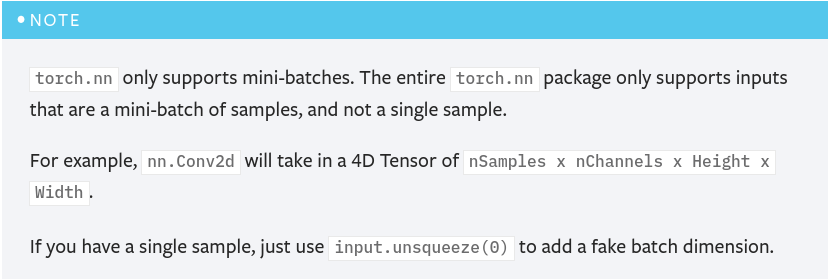

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import models
from torchsummary import summary

# Define model

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3) # input's depth, filters, kernel_size
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        
        x = F.relu(self.conv2(x))
        # If the size is a square you can just specify a single number
        x = F.max_pool2d(x, 2)
        
        x = x.view(-1, self.num_flat_features(x)) # call a class method
        
        # alternatively:
#         x = nn.Flatten()(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        """
        class method: compute the length when flattened 
        """
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


# move model to 'cuda' if possible so that we can use torchvision.summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0

net = Net()
net = net.to(device)

summary(net, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 30, 30]              60
            Conv2d-2           [-1, 16, 13, 13]             880
            Linear-3                  [-1, 120]          69,240
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 81,194
Trainable params: 81,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.31
Estimated Total Size (MB): 0.38
----------------------------------------------------------------


Notice how we didn't define pooling and relu layers because for these layers, which means they are not shown in `summary`. There is no parameter to learn in these layers. (That's why they are called from `nn.functional`)\
If we want, we can still define self.pool and self.relu, and they will be shown in the output of `summary`.

About the flatten layer: Torch provides `nn.Flatten` too, saying it is for Sequential, but it seems we can use it here too.

Alternative to summary, with less information:

In [9]:
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


# Parameters

In [10]:
params = list(net.parameters())

In [11]:
params # a list of tensors

[Parameter containing:
 tensor([[[[-0.3080, -0.2604, -0.2227],
           [-0.1537,  0.0573, -0.3258],
           [ 0.1716, -0.0301,  0.1847]]],
 
 
         [[[ 0.2850, -0.0436, -0.3114],
           [ 0.1176,  0.0130, -0.1022],
           [ 0.2800,  0.0725, -0.0096]]],
 
 
         [[[ 0.2182,  0.2991,  0.0952],
           [ 0.3313,  0.0344,  0.1345],
           [ 0.2368, -0.1747,  0.3143]]],
 
 
         [[[ 0.1717,  0.2396, -0.2088],
           [ 0.0423,  0.1510,  0.0650],
           [ 0.1086,  0.0356, -0.2051]]],
 
 
         [[[-0.0060,  0.2124, -0.0096],
           [ 0.2161,  0.3194,  0.2671],
           [-0.1537,  0.2648, -0.3143]]],
 
 
         [[[ 0.2756,  0.0986,  0.0142],
           [-0.1124,  0.2676,  0.1448],
           [ 0.0817,  0.0523,  0.3161]]]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.2785, -0.2763, -0.0923,  0.2132, -0.3330, -0.0537], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[[[ 1.3421e-01, -1.10

In [12]:
len(params)

10

In [13]:
for i in range(len(params)):
    print(params[i].shape)

torch.Size([6, 1, 3, 3])
torch.Size([6])
torch.Size([16, 6, 3, 3])
torch.Size([16])
torch.Size([120, 576])
torch.Size([120])
torch.Size([84, 120])
torch.Size([84])
torch.Size([10, 84])
torch.Size([10])


Notice how 

In [14]:
6 * 1 * 3 * 3 + 6

60

In [15]:
16 * 6 * 3 * 3 + 16

880

In [16]:
120 * 576 + 120

69240

And so on. Aha: these tensors are weight and bias for each layer.

# Forward pass

In [17]:
# forward pass
x = torch.randn(1, 1, 32, 32).to(device) # have to move the input to device too
out = net(x) # should be a tensor of size 10

# Loss

In [18]:
# dummy true label for illustration
target = torch.randn((1,10)).to(device)

# choose a loss function
loss_fn = nn.MSELoss()

loss = loss_fn(out, target)

In [19]:
print(loss) # a scalar

tensor(0.4268, device='cuda:0', grad_fn=<MseLossBackward>)


More choices for loss functions: https://pytorch.org/docs/stable/nn.html

# Backprop

You need to clear the existing gradients though, else gradients will be accumulated to existing gradients.

In [20]:
net.zero_grad() # refresh gradient buffer

To backpropagate the error all we have to do is to `loss.backward()`:

In [21]:
# inspect the gradient of first conv layer before and after `backward`
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 3.4828e-03, -8.6570e-03,  1.1935e-03,  4.2156e-06, -9.6326e-03,
        -1.6649e-03], device='cuda:0')


# Finally, update the weights

We got the gradients, now update weights:

In [22]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

for i in range(10): # train for 10 iterations
    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output = net(x) # fwd pass
    loss = loss_fn(output, target)
    loss.backward() # bwd pass
    optimizer.step()    # Does the update
    

Notice how we have to clean the gradient buffers after each update.